# Data Understanding

Let's take a quick look at the shape of the data set. We will describre, explore and verify quality of our data.

In [1]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import babel.numbers

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

## Outliers

### Price

Let's have a look at our target variable `price`. It is assumed that the price column is in USD, so we need to look for any extreme or invalid values.

In [3]:
df['price'].describe()

count         426,880.00
mean           75,199.03
std        12,182,282.17
min                 0.00
25%             5,900.00
50%            13,950.00
75%            26,485.75
max     3,736,928,711.00
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

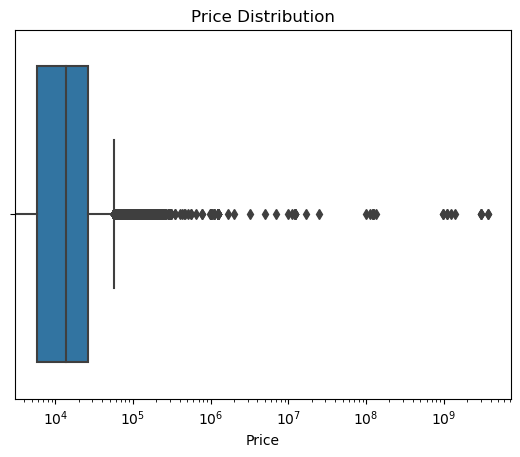

In [4]:
price_plot = sns.boxplot(x = df['price'])
plt.xscale('log')
plt.xlabel('Price')
plt.title('Price Distribution')

We can drop some of the most expensive car entries if the volume is low:

In [5]:
expensive_cars = df[df['price'] > 1000000]
print('Cars over 1M: {0}'.format(len(expensive_cars))) # 53

Cars over 1M: 53


### Year

Let's take a similar approach and look at the year distribution

Text(0.5, 1.0, 'Year Distribution')

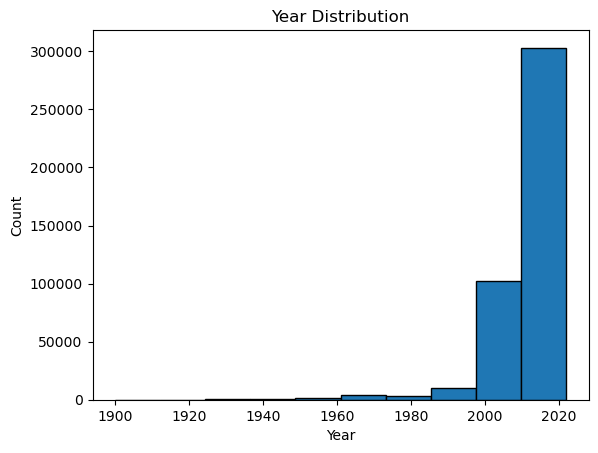

In [6]:
years = df[['year']].dropna()
years['decade'] = years['year'].apply(lambda year: int(year / 10) * 10)

fig, ax = plt.subplots(1)
n, bins, patches = plt.hist(df[['year']].dropna(), edgecolor='black')
plt.xticks(bins)

plt.xscale('linear')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Distribution')

Seems like most vehicles in the dataset are in the range of the 1990's to 2020's, so we could drop the rows that are out of range

## Odometer

In [7]:
odometer = df[['odometer']].dropna()
odometer.describe()

,odometer
count,"422,480.00"
mean,"98,043.33"
std,"213,881.50"
min,0.00
25%,"37,704.00"
50%,"85,548.00"
75%,"133,542.50"
max,"10,000,000.00"


There are some outliers for odometer. Most notable are the max and minium.

array([[<Axes: title={'center': 'odometer'}>]], dtype=object)

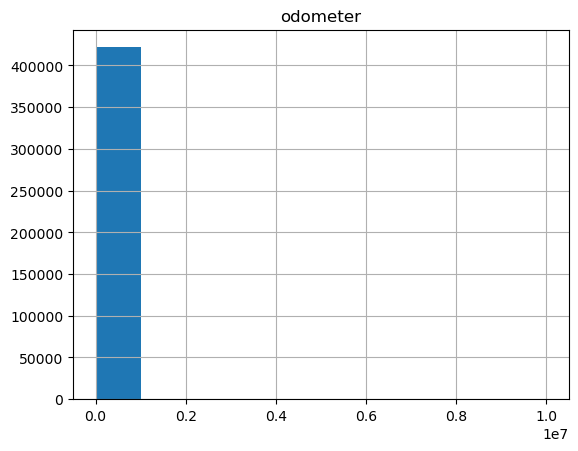

In [8]:
odometer.hist()

## Missing Values

In [9]:
nulls = pd.DataFrame(df.isnull().sum(), columns=['null count'])
nulls['percent of total'] = nulls['null count']*100 / len(df)
nulls.sort_values('percent of total', ascending=False) 

,null count,percent of total
size,306361,71.77
cylinders,177678,41.62
condition,174104,40.79
VIN,161042,37.73
drive,130567,30.59
paint_color,130203,30.50
type,92858,21.75
manufacturer,17646,4.13
title_status,8242,1.93
model,5277,1.24


Based on this, I belive we can do the following:

* Backfill rows without `cylinders` with the average. The assumption is that this is actually an important feature, but the number of records without this is too high to remove.
* Backfill rows without `odometer` using the national average per year.
* Backfill `condition` from odometer and/or year. This is a broad assumption, but this is assumed to be an important feature so we will do out best to keep it.
* Backfill missing `manufacturer` from the `model` column. Use a dictionary of known brands.
* Backfill rows without `drive` with most popular drive.
* Backfill rows without `paint_color` with most popular color.
* Drop column `size`, since it cannot be inferred from any other column
* Drop column `VIN`, `state`, `region`.
* Drop rows without `fuel`, `transmission`, `title_status` and `year`. They have low null counts.
* Drop rows without `type`. This has a high null count, but no way to backfill.
* Drop rows withouth `manufacturer`.
* Drop the `model` column. Keeping this will produce a lot of categorical data and/or too many features to deal with.